In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    torch.cuda.manual_seed(777)
print(device)

cpu


In [4]:
torch.manual_seed(777)
IMAGE_SIZE=128

In [5]:
test_data = ImageFolder(root='data/test_image',
                        transform=transforms.Compose([
                            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                            transforms.ToTensor()
                        ]))

In [6]:
test_load = DataLoader(test_data,
                         batch_size=10,
                         shuffle=True,
                         drop_last=False)

In [7]:
test_img, labels = next(iter(test_load))
print(test_img.size(), labels.size())

torch.Size([10, 3, 128, 128]) torch.Size([10])


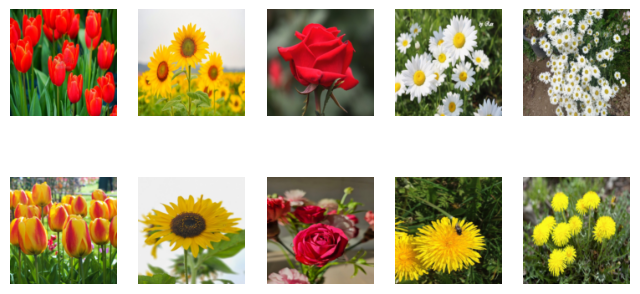

In [10]:
def plot2(x):
    plt.figure(figsize=(8,4))
    for i in range(len(x)):
        plt.subplot(2,5, i+1)
        plt.imshow(x[i].permute(1,2,0))
        # plt.title(y[i].item())
        plt.axis('off')
    plt.show()

plot2(test_img,)

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # ─────────────────────────────────────────────
        # [입력: RGB 이미지 (3채널, 64x64)]로 가정
        # Conv 레이어: 커널 3x3, padding=1 → 크기 유지됨
        # Pooling 레이어: 2x2 max pooling → 크기 절반
        # ─────────────────────────────────────────────

        self.conv1 = nn.Conv2d(3, 8, 3, stride=1, padding=1)     # 입력: (3, 64, 64) → 출력: (8, 64, 64)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=1, padding=1)    # → (16, 32, 32)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=1, padding=1)   # → (32, 16, 16)
        self.conv4 = nn.Conv2d(32, 64, 3, stride=1, padding=1)   # → (64, 8, 8)
        self.conv5 = nn.Conv2d(64, 128, 3, stride=1, padding=1)  # → (128, 4, 4)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 2x2 max pooling (크기 절반)

        # 완전 연결층 (FC)
        self.fc1 = nn.Linear(128 * 4 * 4, 128)  # Flatten된 입력 2048 → 128
        self.fc2 = nn.Linear(128, 64)          # 128 → 64
        self.fc3 = nn.Linear(64, 5)            # 64 → 5 (5개 클래스 분류)

    def forward(self, x):
        # ───── Conv → ReLU → Pooling 반복 구조 ─────

        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.pool(x)  # (8, 64, 64) → (8, 32, 32)

        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = self.pool(x)  # (16, 32, 32) → (16, 16, 16)

        x = self.conv3(x)
        x = nn.ReLU()(x)
        x = self.pool(x)  # (32, 16, 16) → (32, 8, 8)

        x = self.conv4(x)
        x = nn.ReLU()(x)
        x = self.pool(x)  # (64, 8, 8) → (64, 4, 4)

        x = self.conv5(x)
        x = nn.ReLU()(x)
        x = self.pool(x)  # (128, 4, 4) → (128, 2, 2)

        x = x.view(x.size(0), -1)  # Flatten: (batch_size, num_features)
        
        # ───── FC 레이어들 ─────
        x = self.fc1(x)  # (512 → 128)
        x = self.fc2(x)  # (128 → 64)
        x = self.fc3(x)  # (64 → 5)

        # softmax는 CrossEntropyLoss에서 자동 적용되므로 생략
        return x

In [9]:
model = CNN().to(device)
model.load_state_dict(torch.load('data/model.pt'))
model

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=5, bias=True)
)